In [14]:
from PIL import Image, ImageDraw, ImageColor
from glob import glob
import matplotlib.pyplot as plt

%matplotlib inline

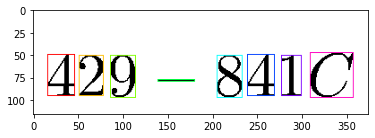

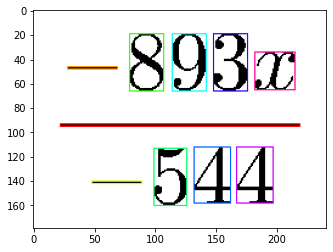

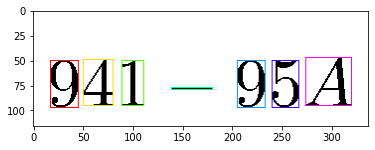

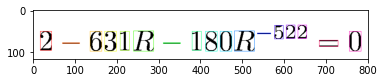

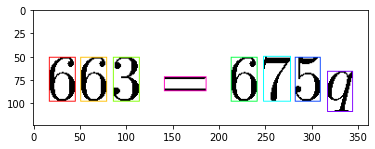

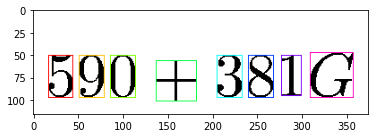

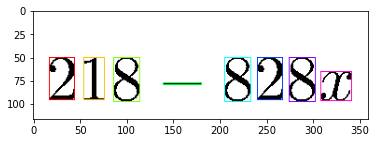

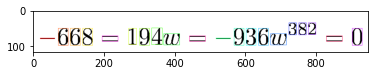

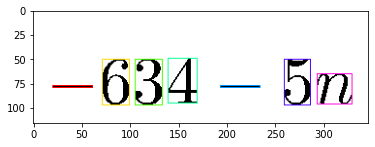

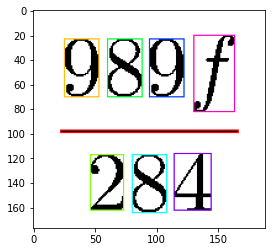

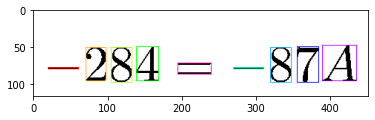

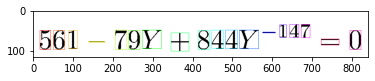

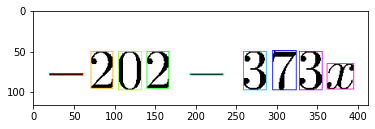

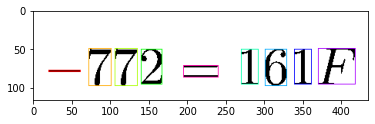

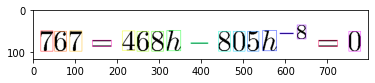

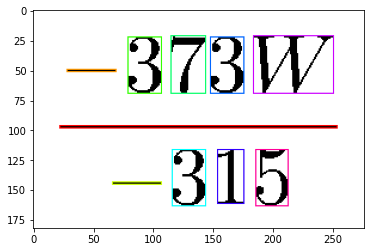

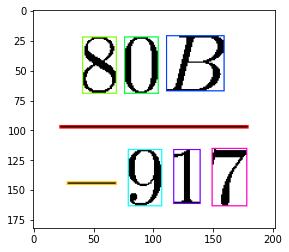

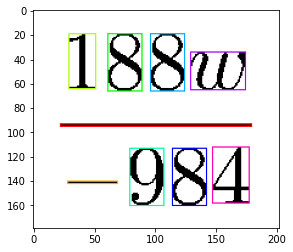

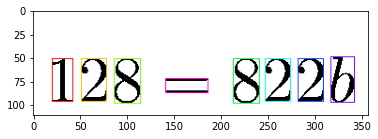

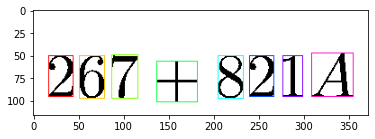

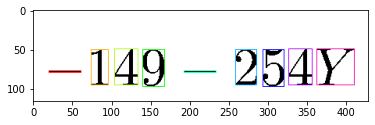

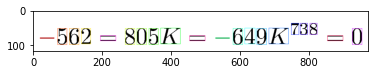

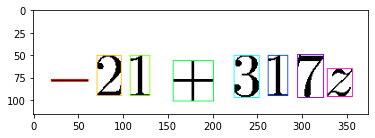

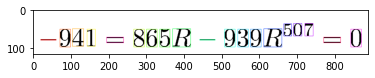

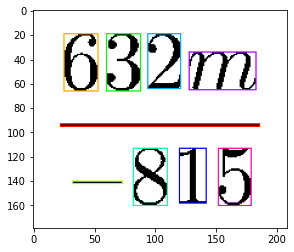

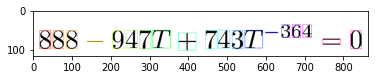

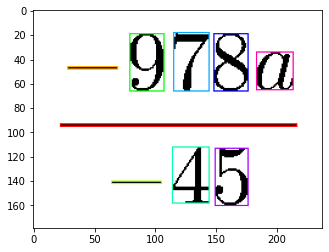

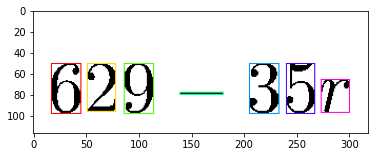

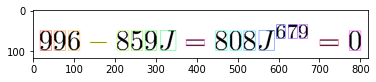

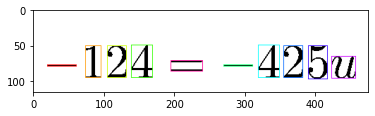

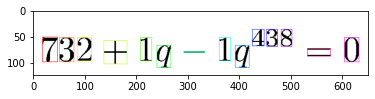

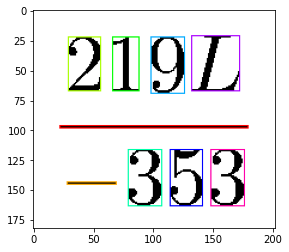

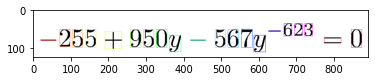

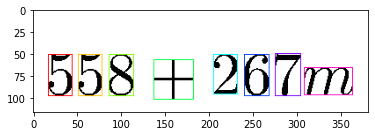

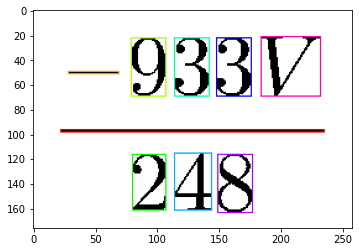

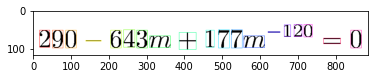

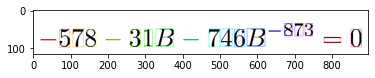

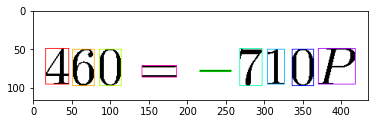

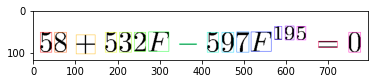

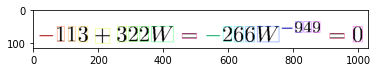

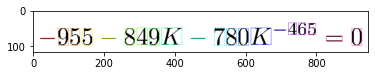

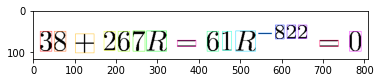

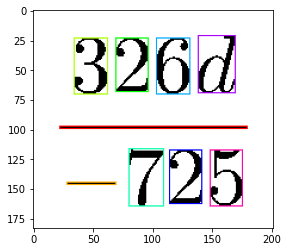

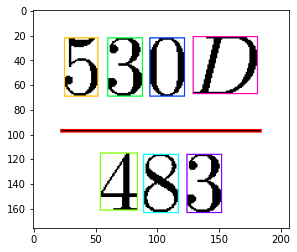

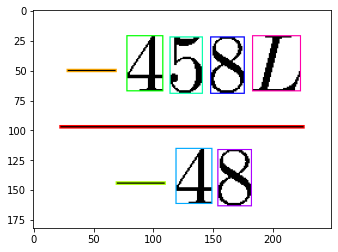

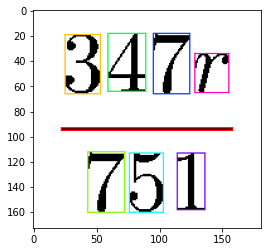

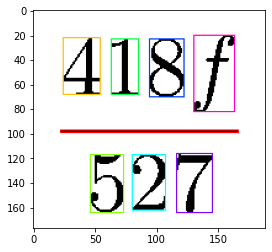

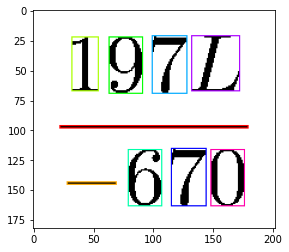

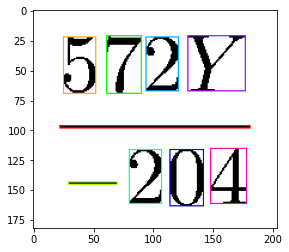

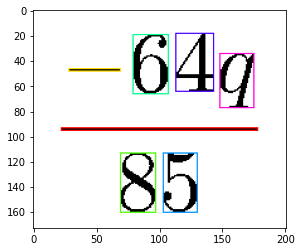

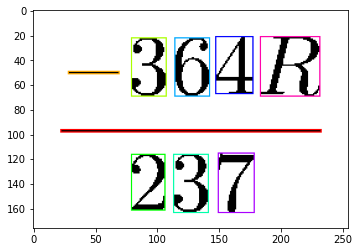

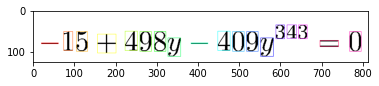

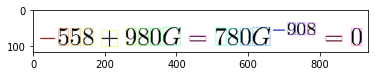

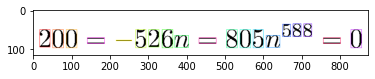

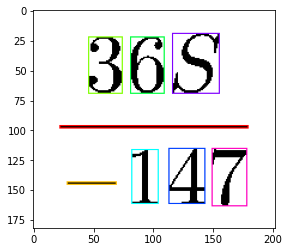

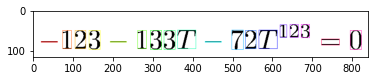

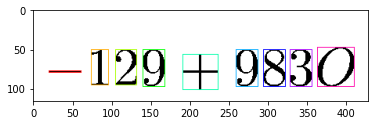

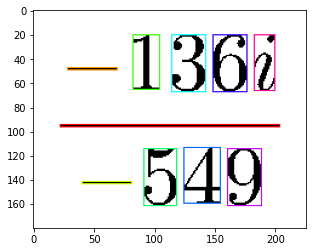

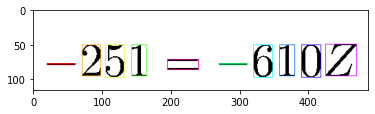

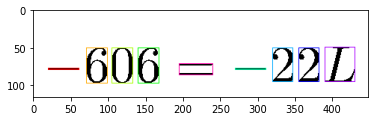

In [15]:
from segmenter.symbol_segmenter import segment_image


def label_image(img):
    crops = segment_image(img)
    labeled_img = img.copy()
    labeled_img = labeled_img.convert('RGB')
    img_d = ImageDraw.Draw(labeled_img)
    
    for i, crop in enumerate(crops):
        img_d.rectangle(crop, outline=ImageColor.getrgb(f'hsl({i/len(crops)*360}, 100%, 50%)'))
        
    return labeled_img


for filename in glob('./dataset/*.png'):
    img = Image.open(filename)
    img = label_image(img)
    
    plt.figure()
    plt.imshow(img)
    plt.show()
